# DBSCAN Clustering on the Wine Dataset

**Goal:**
1. Load and standardize the Wine dataset.
2. Re-run K-Means (K=3) for comparison.
3. Apply DBSCAN and inspect clusters and noise.
4. Quantitatively compare K-Means vs DBSCAN using ARI & silhouette.
5. Visualize both clusterings in 2D via PCA.

## 0. Imports

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

sns.set(style='whitegrid', context='notebook')

## 1. Data Loading & Preprocessing

- Load Wine dataset (178 samples, 13 features).
- Standardize features to mean=0 and variance=1.

In [51]:
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)

X_scaled shape: (178, 13)


## 2. Baseline K-Means (K = 3)

We re-run K-Means to get labels for comparison.

In [52]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
km_labels = kmeans.fit_predict(X_scaled)

# metrics
km_inertia = kmeans.inertia_
km_sil = silhouette_score(X_scaled, km_labels)
km_ari = adjusted_rand_score(y, km_labels)

print(f"K-Means inertia: {km_inertia:.2f}")
print(f"K-Means silhouette score: {km_sil:.3f}")
print(f"K-Means ARI vs true labels: {km_ari:.3f}")

K-Means inertia: 1277.93
K-Means silhouette score: 0.285
K-Means ARI vs true labels: 0.897


## 3. DBSCAN Clustering

- Use eps and min_samples to control neighborhood and noise.
- Inspect how many clusters and how many noise points.

In [53]:
results = []
for eps in [0.8, 1.0, 1.2, 1.5, 2.0, 2.5]:
    for m in [3, 5, 7, 10]:
        db = DBSCAN(eps=eps, min_samples=m).fit(X_scaled)
        lbl = db.labels_
        ncl = len(set(lbl)) - (1 if -1 in lbl else 0)
        nno = np.sum(lbl == -1)
        sil = (silhouette_score(X_scaled[lbl!=-1], lbl[lbl!=-1])
               if ncl > 1 else np.nan)
        results.append((eps, m, ncl, nno, sil))
import pandas as pd
df = pd.DataFrame(results, columns=['eps','min_samp','n_clusters','n_noise','silhouette'])
display(df.sort_values('silhouette', ascending=False).head(10))

,eps,min_samp,n_clusters,n_noise,silhouette
18,2.0,7,3,110,0.441528
12,1.5,3,8,147,0.331067
23,2.5,10,2,32,0.322843
17,2.0,5,5,85,0.240461
16,2.0,3,5,64,0.211348
0,0.8,3,0,178,NaN
1,0.8,5,0,178,NaN
2,0.8,7,0,178,NaN
3,0.8,10,0,178,NaN
4,1.0,3,0,178,NaN


In [54]:
# Try a DBSCAN configuration
eps = 2.5
db = DBSCAN(eps=eps, min_samples=10)
db_labels = db.fit_predict(X_scaled)

# how many clusters (excluding noise label = -1)
labels_unique = set(db_labels)
n_clusters = len(labels_unique) - (1 if -1 in db_labels else 0)
n_noise = np.sum(db_labels == -1)

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")

# compute silhouette only if at least 2 clusters
if n_clusters > 1:
    db_sil = silhouette_score(X_scaled, db_labels)
else:
    db_sil = np.nan
db_ari = adjusted_rand_score(y, db_labels)

print(f"DBSCAN silhouette score: {db_sil}")
print(f"DBSCAN ARI vs true labels: {db_ari:.3f}")

DBSCAN found 2 clusters and 32 noise points.
DBSCAN silhouette score: 0.20438854495188735
DBSCAN ARI vs true labels: 0.424


## 4. Visual Comparison via PCA (2D)

- Project data to 2D with PCA.
- Plot side-by-side: K-Means vs DBSCAN vs True labels.

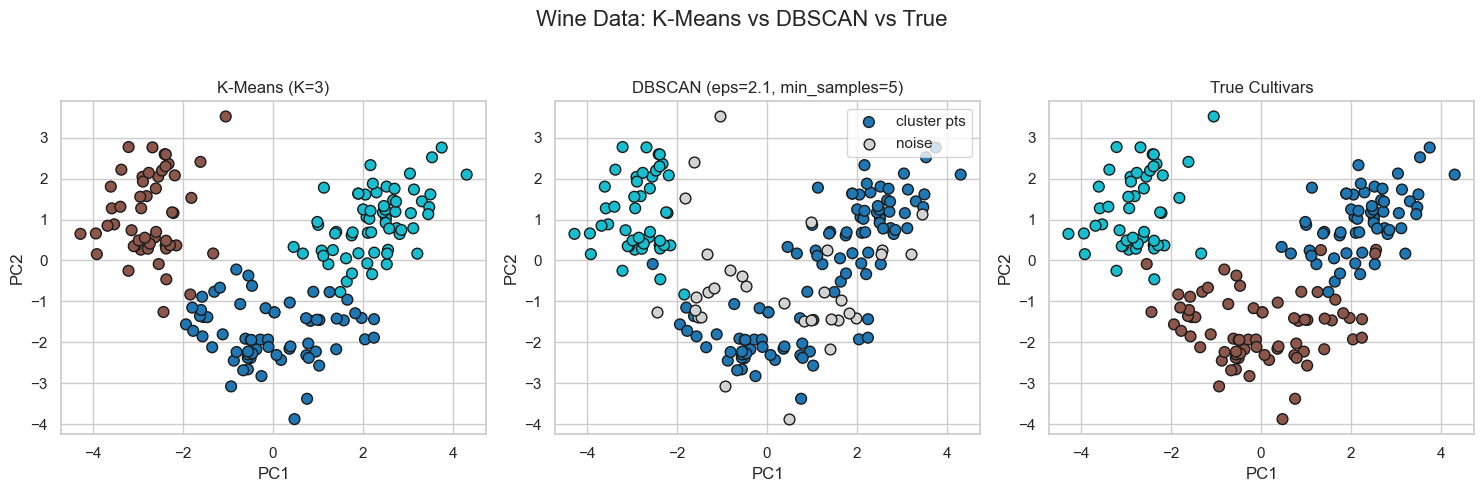

In [55]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(15,5))

# K-Means
axes[0].scatter(
    X_pca[:,0], X_pca[:,1],
    c=km_labels, cmap='tab10', edgecolor='k', s=60)
axes[0].set_title('K-Means (K=3)')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')


# DBSCAN subplot with clusters + noise
core_mask  = db_labels != -1    # points assigned to a real cluster
noise_mask = db_labels == -1    # noise points

# first plot the clustered points
axes[1].scatter(
    X_pca[core_mask, 0], X_pca[core_mask, 1],
    c=db_labels[core_mask],      # 0,1,2 for clusters
    cmap='tab10',
    edgecolor='k', s=60,
    label='cluster pts'
)

# then plot the noise in grey
axes[1].scatter(
    X_pca[noise_mask, 0], X_pca[noise_mask, 1],
    c='lightgrey',
    edgecolor='k', s=60,
    label='noise'
)

axes[1].legend(loc='upper right')
axes[1].set_title('DBSCAN (eps=2.1, min_samples=5)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

# True Labels
axes[2].scatter(
    X_pca[:,0], X_pca[:,1],
    c=y, cmap='tab10', edgecolor='k', s=60)
axes[2].set_title('True Cultivars')
axes[2].set_xlabel('PC1'); axes[2].set_ylabel('PC2')

fig.suptitle('Wine Data: K-Means vs DBSCAN vs True', fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()